In [21]:
!pip install lightkurve
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install tensorflow

In [22]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import scipy
import pandas as pd 
from scipy import interpolate

In [23]:
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [24]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5
        

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# BiSON Data

In [26]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [27]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

In [28]:
def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

In [29]:
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


# Sunspot Count

In [30]:
#sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
sunspot_Day = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

#sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [31]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

In [32]:
def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

In [33]:
getSN_Day(cycle_23)

array([[2.4502965e+06, 2.6000000e+01],
       [2.4502975e+06, 3.1000000e+01],
       [2.4502985e+06, 3.1000000e+01],
       ...,
       [2.4547985e+06, 0.0000000e+00],
       [2.4547995e+06, 0.0000000e+00],
       [2.4548005e+06, 0.0000000e+00]])

In [34]:
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

# Preprocessing

In [56]:
datax_SV = getSV_index(cycle_23)
datay_SV = getSV(cycle_23)


# plt.xlabel('Time (BJD)')
# plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

# #Axis 1
# plt.autoscale(enable=True, axis='both', tight=None)
# plt.scatter(datax_SV,datay_SV, s = 10, c='blue', alpha=0.5)
# plt.show()
print(datax_SV.size)

9730800


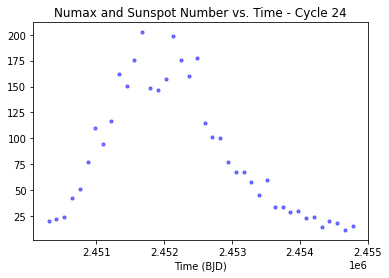

80


In [204]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),115)
# data_SN = np.ma.masked_equal(getSN_Day(cycle_23),0)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]

plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(datax_SN,datay_SN, s = 10, c='blue', alpha=0.5)
plt.show()
print(data_SN.size)

In [200]:
#Interpolation
def interpolate(data, smoothness):
    from scipy import interpolate
    x_new = np.linspace((data[0][0])-1,int(data[-1][0])+1,smoothness)
    a_BSpline = interpolate.make_interp_spline(data.T[0],data.T[1])
    y_new = a_BSpline(x_new)
    return x_new,y_new

In [37]:
def prepXY(datax,datay,duration):
  oldx = np.reshape(datax, (-1, 2160))
  size = (duration-1)/2
  newx = oldx[:int(len(oldx)-size)]
  for i in range(int(size),int(len(oldx)-size)):
    newx[i] = np.append(newx[i],(oldx[i][i-size+j] for j in range(duration)))
  # newx = np.zeros([int(len(datax)/2160-duration),duration])
  # for i in range(int(len(datax)/2160-duration)):
  #   for j in range(duration):
  #     newx[i][j] = datax[i+j]
  # newx = np.array(list(zip(*(datax[i:] for i in range(duration)))))
  newy = datay[int((duration-1)/2):-int((duration-1)/2)]
  return newx, newy

In [42]:
# x, y = prepXY(getSV(cycle_23),getSN_Day(cycle_23).T[1],5)
print(getSV(cycle_23).shape)

(9730800,)


In [208]:
train_x = getSV(cycle_23)
train_y = datay_SN #getSN_Day(cycle_23).T[1]
#train_y = SN_23_AVG.T[1]
print(train_x.shape, train_y.shape)
print(9730800/40)
train_x = np.reshape(train_x, (-1, 243270)) #2160
print(train_x.shape)
print(max(train_y))

# normalize
train_y = np.divide(train_y,353.0)
print(max(train_y),train_y.shape)

(9730800,) (40,)
243270.0
(40, 243270)
202.41739130434783
0.573420371966991 (40,)


In [243]:
check_x = getSV(cycle_24)
check_y = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),115).T[1][:36]
print(check_x.shape, check_y.shape)
check_x = np.reshape(check_x[:-182518], (-1, 243270)) #2160
print(check_x.shape)
print(max(check_y))

# normalize
train_y = np.divide(train_y,353.0)
print(max(check_y),check_y.shape)

(8940238,) (36,)
(36, 243270)
202.41739130434783
202.41739130434783 (36,)


In [271]:
tf.test.gpu_device_name()
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()

model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))
model.add(layers.Dense(128, activation='relu', input_shape=(train_x.shape)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40, 128)           31138688  
_________________________________________________________________
dense_1 (Dense)              (None, 40, 32)            4128      
_________________________________________________________________
dense_2 (Dense)              (None, 40, 1)             33        
Total params: 31,142,849
Trainable params: 31,142,849
Non-trainable params: 0
_________________________________________________________________


In [272]:
# model.compile(optimizer='adam',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [274]:
history = model.fit(train_x, train_y, epochs=100,validation_data=(check_x, check_y))

Epoch 1/100
2/2 [==============================] - 1s 356ms/step - loss: 58.5543 - accuracy: 0.0000e+00 - val_loss: 11721.5859 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 278ms/step - loss: 52.1823 - accuracy: 0.0000e+00 - val_loss: 11735.9854 - val_accuracy: 0.0000e+00
Epoch 3/100
2/2 [==============================] - 0s 260ms/step - loss: 130.6686 - accuracy: 0.0000e+00 - val_loss: 11747.5342 - val_accuracy: 0.0000e+00
Epoch 4/100
2/2 [==============================] - 0s 270ms/step - loss: 194.6126 - accuracy: 0.0000e+00 - val_loss: 11746.0449 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 270ms/step - loss: 74.8485 - accuracy: 0.0000e+00 - val_loss: 11718.4688 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 260ms/step - loss: 111.8237 - accuracy: 0.0000e+00 - val_loss: 11711.3672 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 271ms/step - loss: 

In [275]:
print(history.history)

{'loss': [58.55431365966797, 52.18231964111328, 130.66860961914062, 194.61260986328125, 74.84852600097656, 111.82368469238281, 283.4149169921875, 430.57855224609375, 310.35906982421875, 103.20174407958984, 34.19906234741211, 67.36627197265625, 96.34687042236328, 93.4493179321289, 74.06815338134766, 79.30180358886719, 82.52925872802734, 53.495880126953125, 125.24201965332031, 190.83819580078125, 114.5235824584961, 177.91342163085938, 202.452880859375, 172.1912841796875, 52.667320251464844, 100.06376647949219, 123.8560791015625, 59.8347282409668, 142.55252075195312, 96.14915466308594, 828.12060546875, 280.1563720703125, 2181.989990234375, 1223.039306640625, 229.7216339111328, 204.19081115722656, 437.82537841796875, 374.45355224609375, 913.0322265625, 780.028564453125, 261.728759765625, 286.4190673828125, 401.5435791015625, 676.2927856445312, 492.0810546875, 299.1226501464844, 227.48947143554688, 802.3450927734375, 483.83447265625, 637.8180541992188, 366.1966857910156, 138.26943969726562,

In [276]:
pred_y = model.predict(train_x)

In [277]:
pred_y = pred_y.reshape(-1)
pred_y = np.multiply(pred_y,353.0)
print(pred_y)

[   157.4476      447.60367     101.07623    -373.3559    -1328.1885
   -344.3497      126.66898   -1559.2219     1639.073      -141.06808
  -3231.0974     -617.44116    -371.21887    -346.87286   -3582.2446
    468.16876    -399.67767      49.142864    549.20374   -1049.7269
   1550.8809     -669.0559      599.182      -897.584       463.47827
    -70.2214      986.7729     -634.1564     -327.1477      184.75507
    375.89514     -86.87331   -1092.1431      232.47276  -12835.243
    926.013     12372.379      1092.6046     -117.105865   1031.961   ]


(40,) (40,) (40,)


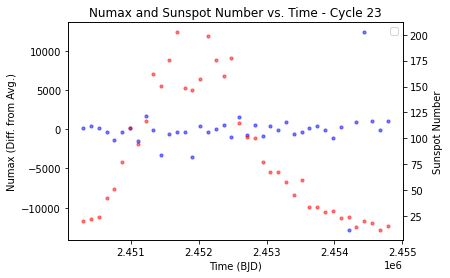

In [278]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),115)
# data_SN = np.ma.masked_equal(getSN_Day(cycle_23),0)
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]
print(datax_SN.shape, datay_SN.shape, pred_y.shape)

figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 23')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('Numax (Diff. from Avg.)')
axis_1.scatter(datax_SN,pred_y, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.scatter(datax_SN,datay_SN, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()

In [279]:
test_x = getSV(cycle_24)[:-182518]
test_x = np.reshape(test_x, (-1,243270))
print(test_x.shape)
test_y = model.predict(test_x)
test_y = test_y.reshape(-1)
test_y = np.multiply(test_y,353.0)
print(test_y)

(36, 243270)
[  -77.795456   688.07025   1990.1287    4080.49      1920.2477
  2402.475       64.051445   824.4145    2391.295    -4166.7676
  -814.17395    153.1536   -1240.2261    1384.2416     587.05786
 -1340.7024   -1987.1251    -161.25858  -1807.5403     296.11377
   974.4947    1586.9109    -526.505     2073.6282     976.94556
  -472.76895   -521.28906  -1561.8296    6986.856      295.73044
  2342.4385    -164.20685  -1377.0377    1279.3286   -1312.977
  2440.1897  ]


(36,) (36,) (36,)


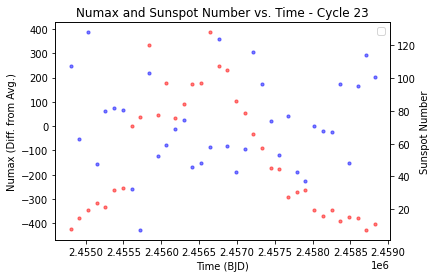

In [270]:
data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),115)
#data_SN = np.ma.masked_equal(getSN_Day(cycle_24),0)[:-1]
datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]
print(datax_SN.shape, datay_SN.shape, test_y.shape)

figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 23')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('Numax (Diff. from Avg.)')
axis_1.scatter(datax_SN,test_y, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.scatter(datax_SN,datay_SN, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()